<a href="https://colab.research.google.com/github/konpatel/pneumonia-detection/blob/master/My_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
train_labels=pd.read_csv("/content/drive/MyDrive/pneumonia/detect-pneumonia/labels_train.csv",dtype=str)
training_dir = '/content/drive/MyDrive/pneumonia/detect-pneumonia/train_images/train_images'
test_dir = '/content/drive/MyDrive/pneumonia/detect-pneumonia/test_images'

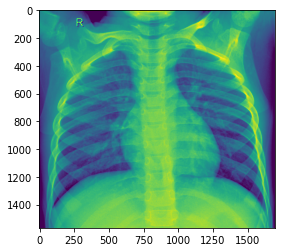

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread(training_dir + '/img_2524489836547201.jpg')
imgplot = plt.imshow(img)
plt.show()

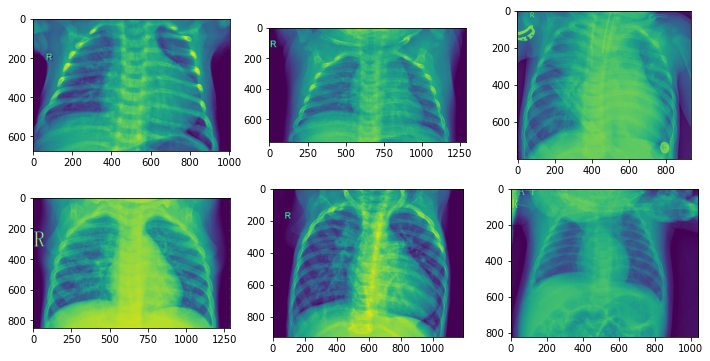

In [4]:
import os

def plot_images(path, labeled=False, max_images=6):
  amount = 0
  fig = plt.figure(figsize=(12, 6))

  for file in os.listdir(path):
    if file.endswith('.jpg'):
      if amount == max_images:
        break

      img = mpimg.imread(os.path.join(path, file))
      plt.subplot(231+amount)
      if labeled:
        plt.title(file.split('_')[1])
      imgplot = plt.imshow(img)

      amount += 1


plot_images(training_dir + '/')

In [5]:
#Διάσταση κάθε εικόνας
IMAGE_SIZE    = (224, 224)
#Αριθμός κατηγοριών που θα γίνει το classification
NUM_CLASSES   = 3
#Σύνολο εικόνων που θα τροφοδοτούμε το μοντέλο κάθε φορά
BATCH_SIZE    = 32  
#Αριθμός layer που θα αποκλείσουμε από το CNN
FREEZE_LAYERS = 2  
#Αριθμός Εποχών
NUM_EPOCHS    = 30
#Filename του μοντέλου
WEIGHTS_FINAL = 'model-final.h5'

In [6]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        validation_split=0.2,
        fill_mode='nearest')

train_generator=datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=training_dir,
    x_col="file_name",
    y_col="class_id",
    subset="training",
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE)

valid_generator =datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=training_dir,
    x_col="file_name",
    y_col="class_id",
    subset="validation",
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    class_mode="categorical",
    target_size=IMAGE_SIZE)

Found 3738 validated image filenames belonging to 3 classes.
Found 934 validated image filenames belonging to 3 classes.


In [7]:
test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_directory(    
    directory=test_dir,    
    seed=42,
    shuffle=False,
    class_mode="categorical",
    batch_size=1,
    target_size=IMAGE_SIZE)
print(test_generator.n)

Found 1168 images belonging to 1 classes.
1168


In [8]:
from keras.layers import Dense, Flatten, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.layers import  Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,BatchNormalization, GlobalAveragePooling2D, Conv2D, MaxPool2D
from keras.models import Sequential
from keras import layers

metrics = ['accuracy']

x_in = Input(shape=[224,224,3])
#First Convolutional layer
conv_layer = Conv2D(filters=16, kernel_size=3, activation='relu', padding="same")
x1 = conv_layer(x_in)
#Second Convolutional layer
x2 = Conv2D(filters=20, kernel_size=3, activation='relu', padding="same")(x1)
#Third Convolutional layer
x3 = Conv2D(filters=32, kernel_size=3, activation='relu', padding="same")(x2)
# Flatten the data
x = Flatten()(x3)   # (32,32,32) --> (32*32*32) --> (32768)
print(x.shape)
# Output fully connected layer with softmax activation
out = Dense(NUM_CLASSES, activation='softmax')(x)

full_model = Model(inputs=x_in, outputs=out)
full_model.compile(optimizer = Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics = metrics)
full_model.summary()

(None, 1605632)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 20)      2900      
                                                                 
 conv2d_2 (Conv2D)           (None, 224, 224, 32)      5792      
                                                                 
 flatten (Flatten)           (None, 1605632)           0         
                                                                 
 dense (Dense)               (None, 3)                 4816899   
                                                                 
Total params: 4,826,039
Trainable params: 4,8

In [9]:
checkpoint = ModelCheckpoint(WEIGHTS_FINAL, monitor='val_accuracy', 
                        verbose=1, save_best_only=True, mode='max')

early = EarlyStopping(monitor='val_accuracy', mode='max', min_delta=1,
                      patience=10, restore_best_weights=True)
callbacks_list = [checkpoint, early]

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

history = full_model.fit(train_generator,
                        validation_data = valid_generator,
                        validation_steps = valid_generator.samples // BATCH_SIZE,
                        epochs = 30,
                        batch_size=32,
                        verbose=1,
                        callbacks=callbacks_list)

# steps_per_epoch = train_generator.samples // BATCH_SIZE,

# save trained weights
full_model.save(WEIGHTS_FINAL)

Epoch 1/30
 25/117 [=====>........................] - ETA: 34:35 - loss: 2.2861 - accuracy: 0.3602

In [ ]:
import matplotlib.pyplot as plt
from google.colab import files

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))
plt.figure()

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.savefig('accuracy.pdf')

files.download('accuracy.pdf')

plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.savefig('Loss.pdf')

files.download('Loss.pdf')

plt.show()

In [ ]:
# load the saved model
from keras.models import load_model
import numpy as np

saved_model = load_model(WEIGHTS_FINAL)
 
test_generator.reset()
print(STEP_SIZE_TEST)
pred=saved_model.predict(test_generator,steps=STEP_SIZE_TEST,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]
filenames=test_generator.filenames


In [ ]:
import re
results=pd.DataFrame({"file_name":filenames,
                      "class_id":predictions})
results.to_csv("test-results.csv",index=False)